In [1]:
import pandas as pd
from LLM_tags_predictor import ask_ollama, compute_jaccard, TAG_VOCAB
import pickle
from sklearn.metrics import jaccard_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import time

2025-05-30 12:25:37.648 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.161 
  command:

    streamlit run c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-30 12:25:38.162 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 12:25:38.165 Session s

In [2]:
data = pd.read_pickle('data/data_170125.pkl')
data = data.sample(150)

data.head()

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding
9225,69173673,0,527,1,2021-09-14 07:33:03,[java],massindexer does not index anything pi am havi...,"[-0.049276374, 0.01934247, 0.049249403, -0.049..."
31537,69802874,2,548,1,2021-11-01 21:16:34,"[java, android]",reaction button like facebook in android pi wa...,"[-0.045043375, 0.003261991, -0.04625422, 0.008..."
48498,65716089,23,24155,1,2021-01-14 09:05:23,[python],no such file or directory gdalconfig pi am try...,"[-0.05613595, 0.016346524, -0.025491387, 0.015..."
22038,69531474,0,317,1,2021-10-11 19:21:34,[javascript],how enable google chrome browser to run local ...,"[0.012481596, 0.02767596, -0.051428612, 0.0243..."
14936,69330780,1,7242,4,2021-09-25 23:33:44,[android],after fixing android gradle plugin requires ja...,"[-0.047418475, 0.009764155, -0.03632176, 0.052..."


In [3]:
data.shape

(150, 8)

In [4]:

# Charger le MultiLabelBinarizer
mlb = pickle.load(open("mlb_use.pkl", "rb"))
TAG_VOCAB = mlb.classes_.tolist()

# Itérer sur le dataset et prédire les tags
predicted_tags_list = []
jaccard_scores = []
f1_scores = []

# Pour calculs finaux
all_y_true = []
all_y_pred = []

for idx, row in tqdm(data.iterrows(), total=len(data)):
    question = row['cleaned_title_body']
    true_tags = row['clean_tags']

    try:
        pred_tags = ask_ollama(question, TAG_VOCAB)
        predicted_tags_list.append(pred_tags)

        # Binariser les tags pour la ligne
        y_true_bin = mlb.transform([true_tags])
        y_pred_bin = mlb.transform([pred_tags])

        # Stocker pour calcul global
        all_y_true.append(y_true_bin[0])
        all_y_pred.append(y_pred_bin[0])

        # Jaccard score par question
        jaccard_scores.append(jaccard_score(y_true_bin, y_pred_bin, average='samples'))

        # F1 score par question
        f1_scores.append(f1_score(y_true_bin, y_pred_bin, average='samples', zero_division=0))

        time.sleep(1.5)  # éviter surcharge serveur Ollama
    except Exception as e:
        predicted_tags_list.append([])
        jaccard_scores.append(0.0)
        f1_scores.append(0.0)
        print(f"⚠️ Erreur à l’index {idx} : {e}")

# Ajouter les résultats au dataframe
data['predicted_tags'] = predicted_tags_list
data['jaccard_score'] = jaccard_scores
data['f1_score'] = f1_scores

c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 150/150 [1:49:22<00:00, 43.75s/it]   


In [5]:
# Conversion en array pour calcul global
import numpy as np
y_true_array = np.array(all_y_true)
y_pred_array = np.array(all_y_pred)

# Moyennes globales
mean_jaccard = jaccard_score(y_true_array, y_pred_array, average='samples')
mean_f1 = f1_score(y_true_array, y_pred_array, average='samples', zero_division=0)

print(f"\n✅ Moyenne Jaccard score (échantillons) : {mean_jaccard:.4f}")
print(f"✅ Moyenne F1 score (échantillons) : {mean_f1:.4f}")


✅ Moyenne Jaccard score (échantillons) : 0.6306
✅ Moyenne F1 score (échantillons) : 0.7249


In [6]:
# Jaccard par tag
jaccard_by_tag = jaccard_score(y_true_array, y_pred_array, average=None)
jaccard_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'jaccard_score': jaccard_by_tag})
print("\n📊 Jaccard score par tag :")
print(jaccard_tag_df.sort_values(by='jaccard_score', ascending=False))


📊 Jaccard score par tag :
          tag  jaccard_score
0     android       0.833333
8      python       0.754098
9     reactjs       0.631579
5  javascript       0.616667
2         css       0.545455
4        java       0.538462
7      pandas       0.500000
3        html       0.500000
1      arrays       0.476190
6     node.js       0.300000


In [7]:
# F1 score par tag (à utiliser avec prudence si certains tags sont rares)
f1_by_tag = f1_score(y_true_array, y_pred_array, average=None, zero_division=0)
f1_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'f1_score': f1_by_tag})
print("\n📊 F1 score par tag (⚠️ sensible aux classes rares) :")
print(f1_tag_df.sort_values(by='f1_score', ascending=False))


📊 F1 score par tag (⚠️ sensible aux classes rares) :
          tag  f1_score
0     android  0.909091
8      python  0.859813
9     reactjs  0.774194
5  javascript  0.762887
2         css  0.705882
4        java  0.700000
7      pandas  0.666667
3        html  0.666667
1      arrays  0.645161
6     node.js  0.461538


In [8]:
pd.set_option('display.max_colwidth', 50)
data.head()

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding,predicted_tags,jaccard_score,f1_score
9225,69173673,0,527,1,2021-09-14 07:33:03,[java],massindexer does not index anything pi am havi...,"[-0.049276374, 0.01934247, 0.049249403, -0.049...",[],0.0,0.000000
31537,69802874,2,548,1,2021-11-01 21:16:34,"[java, android]",reaction button like facebook in android pi wa...,"[-0.045043375, 0.003261991, -0.04625422, 0.008...","[android, java]",1.0,1.000000
48498,65716089,23,24155,1,2021-01-14 09:05:23,[python],no such file or directory gdalconfig pi am try...,"[-0.05613595, 0.016346524, -0.025491387, 0.015...","[python, pandas]",0.5,0.666667
22038,69531474,0,317,1,2021-10-11 19:21:34,[javascript],how enable google chrome browser to run local ...,"[0.012481596, 0.02767596, -0.051428612, 0.0243...","[javascript, html]",0.5,0.666667
14936,69330780,1,7242,4,2021-09-25 23:33:44,[android],after fixing android gradle plugin requires ja...,"[-0.047418475, 0.009764155, -0.03632176, 0.052...","[android, java]",0.5,0.666667


In [9]:
# On change les options pandas pour afficher tout le texte
pd.set_option('display.max_colwidth', None)  # désactive le troncage des colonnes texte
jaccard_null = data.loc[(data['jaccard_score'] == 0) & (data['clean_tags'].apply(lambda tags: 'html' in tags)), ['cleaned_title_body', 'clean_tags']]
jaccard_null.head()

,cleaned_title_body,clean_tags


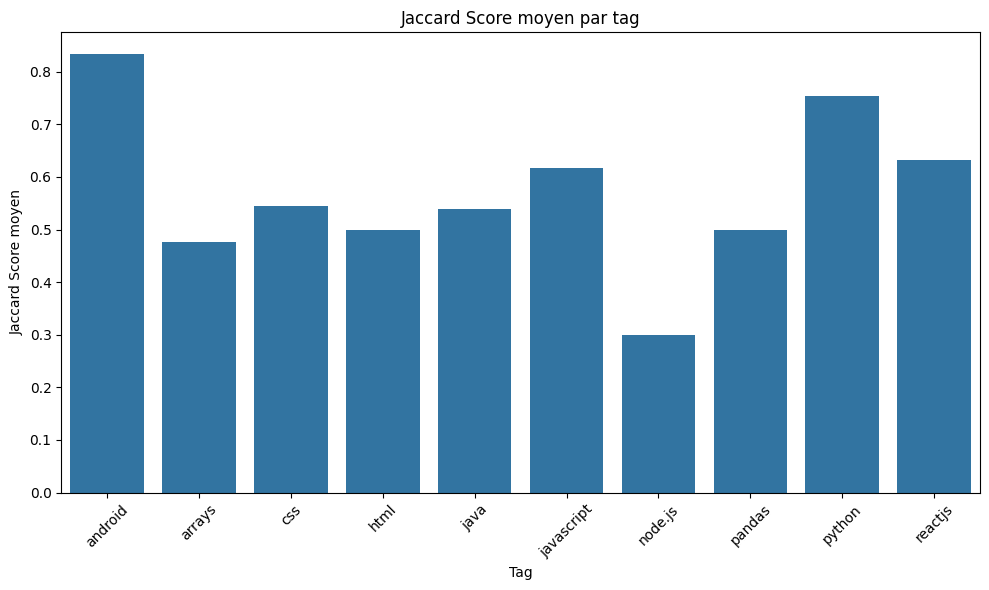

In [10]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt


# Tracé du barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=jaccard_tag_df, x='tag', y='jaccard_score')
plt.title("Jaccard Score moyen par tag")
plt.xlabel("Tag")
plt.ylabel("Jaccard Score moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Sauvegarde des résultats
data.to_pickle("data/results_llm_tags_mistralmini_24b.pkl")

In [29]:
import pandas as pd

# Chargement des résultats
mistral_mini = pd.read_pickle('data/results_llm_tags_mistralmini_24b.pkl')
mistral = pd.read_pickle('data/results_llm_tags_mistral7b.pkl')
deepseek = pd.read_pickle('data/results_llm_tags_deepseek14b.pkl')
llama = pd.read_pickle('data/results_llm_tags_llama3_8b.pkl')

In [30]:
# Calcul des moyennes
results = {
    'mistral_mini': {
        'jaccard_score': mistral_mini['jaccard_score'].mean(),
        'f1_score': mistral_mini['f1_score'].mean()
    },
    'mistral': {
        'jaccard_score': mistral['jaccard_score'].mean(),
        'f1_score': mistral['f1_score'].mean()
    },
    'deepseek': {
        'jaccard_score': deepseek['jaccard_score'].mean(),
        'f1_score': deepseek['f1_score'].mean()
    },
    'llama': {
        'jaccard_score': llama['jaccard_score'].mean(),
        'f1_score': llama['f1_score'].mean()
    }
}

# Construction du DataFrame
df_scores = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_scores.columns = ['model', 'jaccard_score', 'f1_score']

print(df_scores)

          model  jaccard_score  f1_score
0  mistral_mini       0.630556  0.724889
1       mistral       0.614889  0.670698
2      deepseek       0.649667  0.714460
3         llama       0.635444  0.700275
